In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
# Loading the data
products_df = pd.read_json('Products.json')
category_df = pd.read_csv('category.csv')
store_df = pd.read_csv('store.csv')
subcategory_df = pd.read_csv('subcategory.csv')
sales_df = pd.read_csv('sales.csv', parse_dates=['Date'], dayfirst=True)

# Unique counts of Store_ID in sales_df 
sales_df['Store_ID'].nunique()
#print(sales_df)

1

In [4]:
# Check the first few rows of each dataframe
# print(products_df.head())
# print(category_df.head())
# print(store_df.head())
# print(subcategory_df.head())
# print(sales_df.head())

# # Summary statistics
# print(sales_df.describe())

# # Check for missing values
# print(sales_df.isnull().sum())

# type of all columns of sales_df
#print(sales_df.dtypes)

# Convert the 'Date' column to datetime
sales_df['Date'] = pd.to_datetime(sales_df['Date'])
print(sales_df.dtypes)

Date                  datetime64[ns]
Product_ID                    object
Store_ID                      object
Promotion_Flag               float64
 Discount_percent            float64
Price                        float64
Sold_Units                   float64
Sales_Volume                 float64
dtype: object


In [5]:
#Rename ' Discount_percent ' column to 'Discount_percent'
sales_df.rename(columns={' Discount_percent ': 'Discount_percent'}, inplace=True)

# Fill missing values or drop rows/columns if necessary
sales_df['Promotion_Flag'].fillna(0, inplace=True)  # Assuming no promotion if null
sales_df['Discount_percent'].fillna(0, inplace=True)  # Assuming no discount if null

print(sales_df.head())
sales_df.dropna(inplace=True)  # Drop rows with missing values

# Convert data types if needed
sales_df['Discount_percent'] = sales_df['Discount_percent'].astype(float)

#check total number of rows in sales_df
print(sales_df.count())
sales_df_first = sales_df

        Date Product_ID Store_ID  Promotion_Flag  Discount_percent  Price  \
0 2017-01-01        P1_      S7_             0.0               0.0   75.0   
1 2017-01-02        P1_      S7_             0.0               0.0   75.0   
2 2017-01-03        P1_      S7_             0.0               0.0   75.0   
3 2017-01-04        P1_      S7_             0.0               0.0   75.0   
4 2017-01-05        P1_      S7_             0.0               0.0   75.0   

   Sold_Units  Sales_Volume  
0         0.0           0.0  
1         0.0           0.0  
2         0.0           0.0  
3         0.0           0.0  
4         0.0           0.0  
Date                19992
Product_ID          19992
Store_ID            19992
Promotion_Flag      19992
Discount_percent    19992
Price               19992
Sold_Units          19992
Sales_Volume        19992
dtype: int64


RMSE: 463614.58455122885
R2: 0.5394028225536055


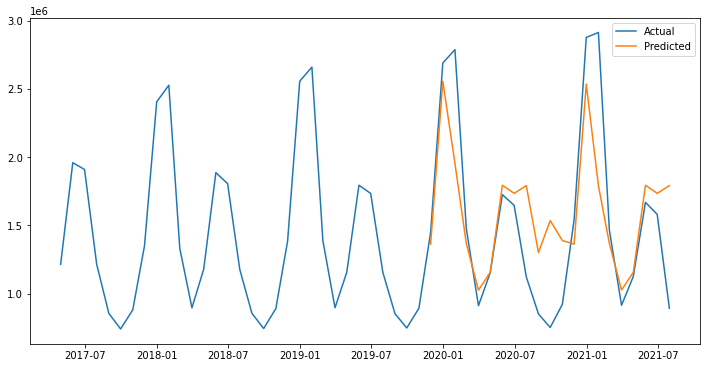

In [6]:
#sales_df = sales_df_first
# Aggregate sales data by date
daily_sales = sales_df.groupby('Date')['Sales_Volume'].sum().reset_index()

# Set the date as the index
daily_sales.set_index('Date', inplace=True)

# Resample to monthly sales volume
monthly_sales = daily_sales.resample('M').sum()
#print(monthly_sales.head())

# XGBoost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def lagged_data(data, lag=1):
    data_lagged = pd.concat([data.shift(i) for i in range(lag, -1, -1)], axis=1)
    data_lagged.columns = [f'X-{i}' for i in range(lag, -1, -1)]
    data_lagged = data_lagged.dropna()
    return data_lagged

# Create lagged data
lag = 3
data_lagged = lagged_data(monthly_sales, lag=lag)
X = data_lagged.drop('X-0', axis=1)
y = data_lagged['X-0']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

# Fitting the model
model = XGBRegressor()
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Calculating the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')
#calculate r2_score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'R2: {r2}')

# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual')
plt.plot(pd.Series(y_pred, index=y_test.index), label='Predicted')
plt.legend()
plt.show()

c:\Users\Prerana\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


RMSE: 77615.31136238344
R2: 0.9846145390352369


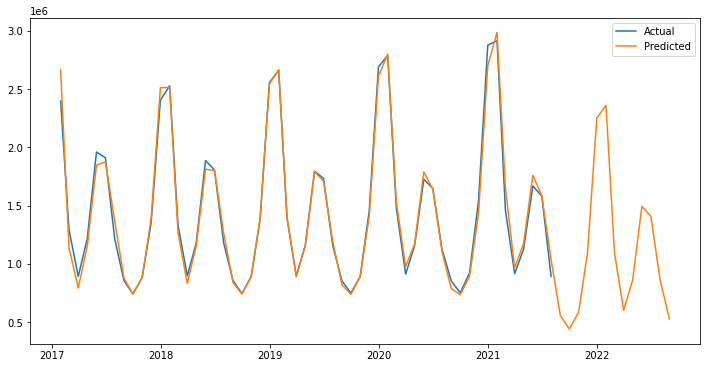

In [9]:
# Aggregate sales data by date
daily_sales = sales_df.groupby('Date')['Sales_Volume'].sum().reset_index()

# Set the date as the index
daily_sales.set_index('Date', inplace=True)

# Resample to monthly sales volume
monthly_sales = daily_sales.resample('M').sum()

# Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fitting the model
model = ExponentialSmoothing(monthly_sales, trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()

# Making predictions
y_pred = model_fit.predict(start=0, end=len(monthly_sales) + 12)

# Calculating the RMSE
rmse = np.sqrt(mean_squared_error(monthly_sales, y_pred[:len(monthly_sales)]))
print(f'RMSE: {rmse}')
#calculate r2_score
from sklearn.metrics import r2_score
r2 = r2_score(monthly_sales, y_pred[:len(monthly_sales)])
print(f'R2: {r2}')

# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()






RMSE: 56144.30889272537
R2: 0.9923060085184088


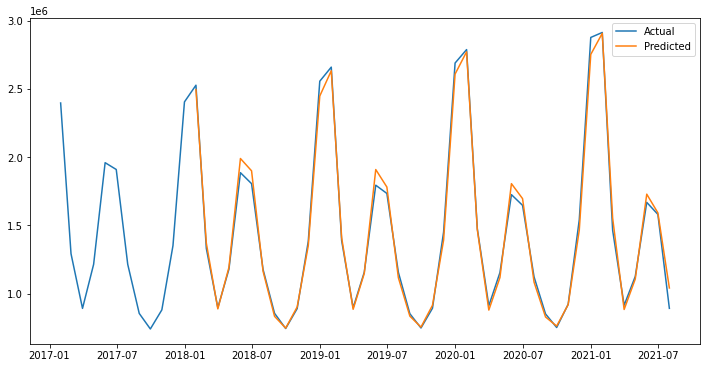

In [10]:
# Aggregate sales data by date
daily_sales = sales_df.groupby('Date')['Sales_Volume'].sum().reset_index()

# Set the date as the index
daily_sales.set_index('Date', inplace=True)

# Resample to monthly sales volume
monthly_sales = daily_sales.resample('M').sum()

# logistc regression model for sales prediction
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Create lag features for the Linear Regression model
def create_lag_features(data, lags):
    lagged_data = pd.DataFrame(index=data.index)
    lagged_data['target'] = data.values
    for lag in lags:
        lagged_data[f'lag_{lag}'] = data.shift(lag)
    return lagged_data.dropna()

# Define lags
lags = [1, 3, 6, 12]

# Create lagged features
lagged_data = create_lag_features(monthly_sales, lags)

# Splitting the data into train and test sets
train_data, test_data = train_test_split(lagged_data, test_size=0.2, shuffle=False)

# Separating features and target variable
X_train, y_train = train_data.drop(columns=['target']), train_data['target']
X_test, y_test = test_data.drop(columns=['target']), test_data['target']

# Fitting the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Combining train and test predictions
y_pred = np.concatenate([y_pred_train, y_pred_test])

# Calculating the RMSE
rmse = np.sqrt(mean_squared_error(lagged_data['target'], y_pred))
print(f'RMSE: {rmse}')

# Calculating the R2 score
r2 = r2_score(lagged_data['target'], y_pred)
print(f'R2: {r2}')

# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Actual')
plt.plot(lagged_data.index, y_pred, label='Predicted')
plt.legend()
plt.show()



RMSE: 38724.015560017564
R2: 0.996339832229516


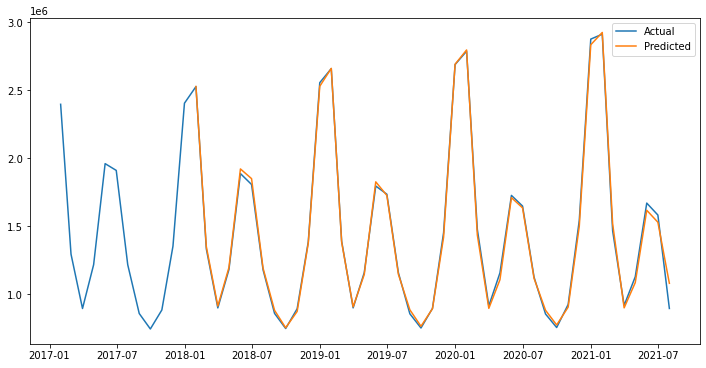

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Aggregate sales data by date
daily_sales = sales_df.groupby('Date')['Sales_Volume'].sum().reset_index()

# Set the date as the index
daily_sales.set_index('Date', inplace=True)

# Resample to monthly sales volume
monthly_sales = daily_sales.resample('M').sum()

# Create lag features for the Ridge Regression model
def create_lag_features(data, lags):
    lagged_data = pd.DataFrame(index=data.index)
    lagged_data['target'] = data.values
    for lag in lags:
        lagged_data[f'lag_{lag}'] = data.shift(lag)
    return lagged_data.dropna()

# Define lags
lags = [1, 2, 3, 4, 5, 6, 12]

# Creating lagged features
lagged_data = create_lag_features(monthly_sales, lags)

# Splitting the data into train and test sets
train_data, test_data = train_test_split(lagged_data, test_size=0.2, shuffle=False)

# Separate features and target variable
X_train, y_train = train_data.drop(columns=['target']), train_data['target']
X_test, y_test = test_data.drop(columns=['target']), test_data['target']

# Fitting the Ridge Regression model
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# Making predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Combining train and test predictions
y_pred = np.concatenate([y_pred_train, y_pred_test])

# Calculating the RMSE
rmse = np.sqrt(mean_squared_error(lagged_data['target'], y_pred))
print(f'RMSE: {rmse}')

# Calculating the R2 score
r2 = r2_score(lagged_data['target'], y_pred)
print(f'R2: {r2}')

# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Actual')
plt.plot(lagged_data.index, y_pred, label='Predicted')
plt.legend()
plt.show()


In [12]:
# #Trying by Random Forest Regressor
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# from xgboost import XGBRegressor

# # Step 1: Load the Data
# products_df = pd.read_json('Products.json')
# category_df = pd.read_csv('category.csv')
# store_df = pd.read_csv('store.csv')
# subcategory_df = pd.read_csv('subcategory.csv')
# sales_df = pd.read_csv('sales.csv')

# # Step 2: Data Exploration
# # Explore the first few rows of each dataframe to understand the structure
# print(products_df.head())
# print(category_df.head())
# print(store_df.head())
# print(subcategory_df.head())
# print(sales_df.head())

# # Examine basic information and missing values
# print(products_df.info())
# print(sales_df.info())

# # Step 3: Data Cleaning

# # Convert the 'Date' column to datetime
# sales_df['Date'] = pd.to_datetime(sales_df['Date'])
# # Convert 'Date' to datetime format for the 'sales_df'
# #sales_df['Date'] = pd.to_datetime(sales_df['Date'], format='%d-%m-%Y')

# #----------------------------------------------------------------------------------------------------------------
# #Rename ' Discount_percent ' column to 'Discount_percent'
# sales_df.rename(columns={' Discount_percent ': 'Discount_percent'}, inplace=True)

# # Fill missing values or drop rows/columns if necessary
# sales_df['Promotion_Flag'].fillna(0, inplace=True)  # Assuming no promotion if null
# sales_df['Discount_percent'].fillna(0, inplace=True)  # Assuming no discount if null
# sales_df.dropna(inplace=True)  # Drop rows with missing values

# # Convert data types if needed
# sales_df['Discount_percent'] = sales_df['Discount_percent'].astype(float)
# #change sales_df['Product_ID'] which has P1_, P2_ to int64 1,2,3..., change from P1_(P1underscore) to 1, P2_ to 2 and so on
# sales_df['Product_ID'] = sales_df['Product_ID'].str.replace('P', '')
# sales_df['Product_ID'] = sales_df['Product_ID'].str.replace('_','').astype('int64')

# category_df['Category_ID'] = category_df['Category_ID;Category_Label'].str.split(';').str[0].astype('int64')
# category_df['Category_Label'] = category_df['Category_ID;Category_Label'].str.split(';').str[1]
# category_df.drop('Category_ID;Category_Label', axis=1, inplace=True)

# subcategory_df['SubCategory_ID'] = subcategory_df['SubCategory_ID;SubCategory_Label'].str.split(';').str[0].astype('int64')
# subcategory_df['SubCategory_Label'] = subcategory_df['SubCategory_ID;SubCategory_Label'].str.split(';').str[1]
# subcategory_df.drop('SubCategory_ID;SubCategory_Label', axis=1, inplace=True)

# store_df['StoreID'] = store_df['StoreID'].str.replace('S', '')
# store_df['StoreID'] = store_df['StoreID'].str.replace('_','').astype('int64')

# sales_df['Store_ID'] = sales_df['Store_ID'].str.replace('S', '')
# sales_df['Store_ID'] = sales_df['Store_ID'].str.replace('_','').astype('int64')

# sales_df_first = sales_df
# #-----------------------------------------------------------------------------------------------------
# # Step 4: Data Merging
# # Merging datasets into a single DataFrame based on 'Product_ID', 'Category_ID', 'StoreID', and 'SubCategory_ID'

# merged_df = sales_df.merge(products_df, on='Product_ID')
# merged_df = merged_df.merge(category_df, left_on='Category', right_on='Category_ID')
# merged_df = merged_df.merge(subcategory_df, left_on='SubCategory', right_on='SubCategory_ID')

# # Merge both the table But store_ID is not unique in both store_df and merged_df
# merged_df = merged_df.merge(store_df, left_on='Store_ID', right_on='StoreID')
# # Step 5: Visualization
# # Plot the sales volume over monthly time to understand trends 

# plt.figure(figsize=(10,5))
# merged_df.groupby('Date')['Sales_Volume'].sum().plot()
# plt.title('Total Sales Volume Over Time')
# plt.show()

# # Step 6: Feature Engineering
# # Create new features, for example, day of the week, month, and year from the 'Date' column
# merged_df['Year'] = merged_df['Date'].dt.year
# merged_df['Month'] = merged_df['Date'].dt.month
# merged_df['DayOfWeek'] = merged_df['Date'].dt.dayofweek

# #prind head of merged_df
# print(merged_df.head())

# # # Step 7: Model Selection
# # # For this example, we will use a XGBoost Regressor
# # model = XGBRegressor(n_estimators=100, random_state=42)

# # # Step 8: Model Training (Monthly)
# # # Split the data into features (X) and target (y)
# # x = merged_df[[ 'Month', 'Promotion_Flag', 'Discount_percent', 'Price']]
# # y = merged_df['Sales_Volume']
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # # Fit the model to the training data
# # model.fit(X_train, y_train)

# # # Step 9: Forecasting
# # # Use the trained model to predict the test set
# # predictions = model.predict(X_test)

# # # Step 10: Evaluation
# # # Evaluate the model's performance using Mean Squared Error (MSE)
# # mse = mean_squared_error(y_test, predictions)

# # print(f"The Mean Squared Error of the forecast model is: {mse}")

# # # Step 11: Visualization
# # # Plot the actual vs predicted sales volume (pd.series)
# # plt.figure(figsize=(30,15))
# # plt.plot(y_test.values, label='Actual')
# # plt.plot(predictions, label='Predicted')
# # plt.title('Actual vs Predicted Sales Volume')
# # plt.legend()
# # plt.show()


In [13]:
# #write a flask app to predict sales volume
# from flask import Flask, request, jsonify
# import pandas as pd
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import train_test_split

# app = Flask(__name__)

# # Aggregate sales data by date
# daily_sales = sales_df.groupby('Date')['Sales_Volume'].sum().reset_index()

# # Set the date as the index
# daily_sales.set_index('Date', inplace=True)

# # Resample to monthly sales volume
# monthly_sales = daily_sales.resample('M').sum()

# # Create lag features for the Linear Regression model
# def create_lag_features(data, lags):
#     lagged_data = pd.DataFrame(index=data.index)
#     lagged_data['target'] = data.values
#     for lag in lags:
#         lagged_data[f'lag_{lag}'] = data.shift(lag)
#     return lagged_data.dropna()

# # Define lags
# lags = [1, 3, 6, 12]

# # Create lagged features
# lagged_data = create_lag_features(monthly_sales, lags)

# # Split the data into train and test sets
# train_data, test_data = train_test_split(lagged_data, test_size=0.2, shuffle=False)

# # Separate features and target variable
# X_train, y_train = train_data.drop(columns=['target']), train_data['target']
# X_test, y_test = test_data.drop(columns=['target']), test_data['target']

# # Fit the Linear Regression model
# model = LinearRegression()
# model.fit(X_train, y_train)

# # Make predictions
# y_pred_train = model.predict(X_train)
# y_pred_test = model.predict(X_test)

# # Combine train and test predictions
# y_pred = np.concatenate([y_pred_train, y_pred_test])

# # Calculate the RMSE
# rmse = np.sqrt(mean_squared_error(lagged_data['target'], y_pred))
# print(f'RMSE: {rmse}')

# # Calculate the R2 score
# r2 = r2_score(lagged_data['target'], y_pred)
# print(f'R2: {r2}')

# # Define a function to predict sales volume
# def predict_sales_volume(data):
#     # Create lagged features
#     lagged_data = create_lag_features(data, lags)
    
#     # Separate features and target variable
#     X, y = lagged_data.drop(columns=['target']), lagged_data['target']
    
#     # Make predictions
#     y_pred = model.predict(X)

#     return y_pred

# # Define a route to predict sales volume
# @app.route('/predict', methods=['POST'])
# def predict():
#     data = request.get_json()
#     data = pd.Series(data)
    
#     # Predict sales volume
#     y_pred = predict_sales_volume(data)
#     #print(y_pred)

#     # Return the predictions
#     return jsonify(y_pred.tolist())

# # Run the app
# if __name__ == '__main__':
#     app.run(debug=True)
